# MultiLinear regression models

## Linear regression theory

We assume here that $ y | X ; \theta\sim\mathcal{N}(\mu,\sigma ^2)$!!

* **Normal equations** - By noting $X$ the design matrix, the value of $\theta$ that minimizes the cost function is a closed-form solution such that:

$$
\boxed{\theta=(X^TX)^{-1}X^Ty}
$$ 

* **LMS algorithm** - By noting $\alpha$ the learning rate, the update rule of the Least Mean Squares (LMS) algorithm for a training set of $m$ data points, which is also known as the Widrow-Hoff learning rule, is as follows:

$$
\boxed{\forall j,\quad \theta_j \leftarrow \theta_j+\alpha\sum_{i=1}^m\left[y^{(i)}-h_\theta(x^{(i)})\right]x_j^{(i)}}
$$

```{note}
Remark: the update rule is a particular case of the gradient ascent
```

* **LWR** - Locally Weighted Regression, also known as LWR, is a variant of linear regression that weights each training example in its cost function by $w^{(i)}(x)$, which is defined with parameter $\tau\in\mathbb{R}$ as:

$$
\boxed{w^{(i)}(x)=\exp\left(-\frac{(x^{(i)}-x)^2}{2\tau^2}\right)}
$$

* **Assumptions of GLMs** - Generalized Linear Models (GLM) aim at predicting a random variable $y$ as a function of $x\in\mathbb{R}^{n+1}$ and rely on the following 3 assumptions:

$$
\quad\boxed{y|x;\theta\sim\textrm{ExpFamily}(\eta)}\textrm{    (1)}
\quad\boxed{h_\theta(x)=E[y|x;\theta]}\textrm{    (2)}
\quad\boxed{\eta=\theta^Tx}\textrm{    (3)}
$$

```{tip}
Remark: ordinary least squares and logistic regression are special cases of generalized linear models
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# maths
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.linear import MultiLinear_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

## Load the data (main + PCs)

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

Moreover, we will load the previously calculated regional PCs, as it takes some time to calculate them. Have in mind that principal component analysis involves "difficult" matrices multiplications / inversions, and with the regional slp fields + the gradient, we have thousands of variables!!

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True,
        pca_plot=(True,False)
    )

## Linear regression with regional predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

In [4]:
run = False
if run:
    # perform the Multilinear-Regression (regional)
    stats_regional = []
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),5
    )
    for stat in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            pcs_cfsr, ss_moana, verbose=False
        ) # pre-loaded pcs
        stats_regional.append(stats_stat)
    # save the statistics
    stats_regional = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_regional)[:,0]),
            'si':(('station'),np.array(stats_regional)[:,1]),
            'rmse':(('station'),np.array(stats_regional)[:,2]),
            'pearson':(('station'),np.array(stats_regional)[:,3]),
            'spearman':(('station'),np.array(stats_regional)[:,4]),
            'rscore':(('station'),np.array(stats_regional)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon)
        },
        coords={
            'station': sites_regional
        }
    )
    # local copy
    if True:
        stats_regional.to_netcdf(data_path+'/statistics/stats_lm_regional_daily.nc')
else:
    stats_regional = xr.open_dataset(
        data_path+'/statistics/stats_lm_regional_daily.nc'
    )

### Validation statistics explanation

When measuring the goodness of a fit, we can calculate very different statistical measures, such as the bias, the rmse or the pearson and spearman correlation coefficients. In this part, we will briefly describe how all of them work, and how they must be interpreted:

* [Bias](https://en.wikipedia.org/wiki/Bias_(statistics)): This is the difference in the means of the predicted and real observations, and should be interpreted as how much the majority of the poinis differ from the real points, in terms of the mean.

$$
\boxed{
\textrm{BIAS:  } = \frac{\sum_{i=1}^Ny_{i \textrm{ (real) }}}{N} - \frac{\sum_{i=1}^Ny_{i \textrm{ (pred) }}}{N}
}
$$

* [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation): The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSE represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various data points into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.

$$
\boxed{
\textrm{RMSE:  } = \sqrt{\frac{\sum_{i=1}^N \left(y_{i \textrm{ (real) }}-y_{i \textrm{ (pred) }}\right)^2}{N}}
}
$$

* [SI](https://www.sciencedirect.com/science/article/pii/S1463500313001418): When using the BIAS and the RMSE, we are not paying attention to some important features in our fit, and they are both dependent on the magnitude of the measures. Here, we introduce the scatter index (SI), which tries to measure the dispersion of the points from the bisection (0,0) to (x,x).

$$
\boxed{
\textrm{SI:  } = \sqrt{
\frac{\sum_{i=1}^N \left[
\left(P_i-\bar{P}\right) - \left(O_i-\bar{O}\right)\right]^2}{\sum_{i=1}^N O_i^2}
}}
$$

where $\bar{P}$ and $\bar{O}$ are the predicted and observed means!!

* [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) correlation coefficients: In statistics, the Pearson correlation coefficient is a measure of linear correlation between two sets of data. It is the covariance of two variables, divided by the product of their standard deviations; thus it is essentially a normalised measurement of the covariance, such that the result always has a value between −1 and 1. As with covariance itself, the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation. As a simple example, one would expect the age and height of a sample of teenagers from a high school to have a Pearson correlation coefficient significantly greater than 0, but less than 1 (as 1 would represent an unrealistically perfect correlation).The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses [monotonic](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/linear-nonlinear-and-monotonic-relationships/) relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other. Equations below:

$$
\boxed{ \textrm{Pearson's  } \rightarrow
\rho _{X,Y} = \frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}} \simeq
\boxed{ r_{xy}={\frac {\sum _{i=1}^{N}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{N}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{N}(y_{i}-{\bar {y}})^{2}}}}}}
\\\\
\boxed{ \textrm{Spearman's  } \rightarrow
\rho _{rg_X,rg_Y} = \frac {\operatorname {cov} (rg_X,rg_Y)}{\sigma _{rg_X}\sigma _{rg_Y}}}
$$

as the Spearman correlation refers here to the [rank variables](https://en.wikipedia.org/wiki/Ranking).

* [R score](https://en.wikipedia.org/wiki/Coefficient_of_determination): The coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It is a statistic used in the context of statistical models whose main purpose is either the prediction of future outcomes or the testing of hypotheses, on the basis of other related information. It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. It is internaly used in the main pachake we are constantly using, so please have a look at the python documentation for further information [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)!!

$$
\boxed{R^2=1-\frac{SS_{res}}{SS_{tot}}}
$$

where $SS_{tot}$ and $SS_{res}$ refer to the total sum of squares (proportional to the variance of the data):
$SS_{tot}=\sum _{i}(y_{i}-{\bar {y}})^{2}$ and the sum of squares of residuals, also called the residual sum of squares: $SS_{res}=\sum _{i}(y_{i}-f_{i})^{2}=\sum _{i}e_{i}^2$.

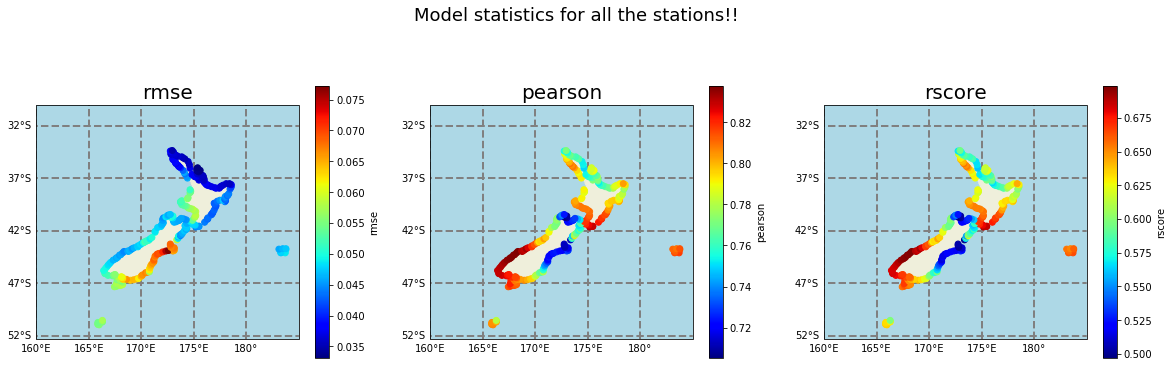

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_regional,plot_stats=['rmse','pearson','rscore'])

```{tip}
Images generated by code, as the one above, can be easily open in a new window, as they have all been generated with good quality for this particular purpose!!
```

### Linear regression in the UHSLC tidal gauges + validation

Here, we really use for the first time our "validators", which are the main truth in the project. In coastal engineering, we usually use the buoys (if we are working with waves) and the tidal gauges (water elevation) as the real observations, and once they are processed, which is the case of these nodes shown here, they might be used as the data to validate with.

Below, apart from plotting the location of the different tidal gauges that we will be working with, we show how the linear regression with the regional predictor behaves in the nearest locations to the tidal gauges, and how this pre-trained linear regression model performs in that tidal gauge too.

To understand how good or bad the linear model might behave when predicting the storm surge of the tidal guages, we find the answer in the validations we performed in the first notebook, called **Data visualization and validation (data_visualization.ipynb)**, where the comparison of all the tidal gauges and the nearest moana nodes is shown.

```{warning}
This use of the pre-trained linear model with the moana nodes for the tidal gauges must be revised, as the distances between both locations might involve the appearance of new physical phenomenons!!
```

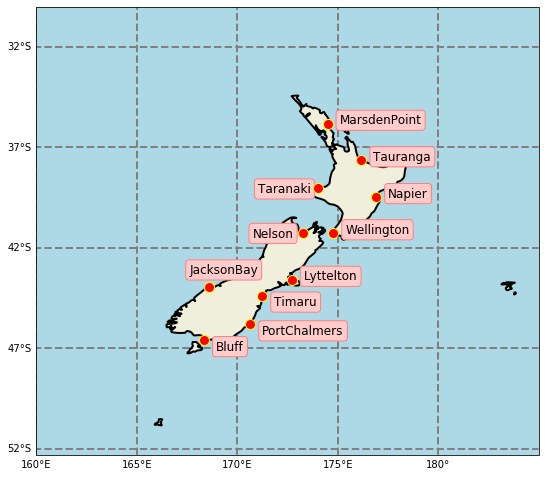

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 139 PCs (0.95 expl. variance) will be used to train the model!! 



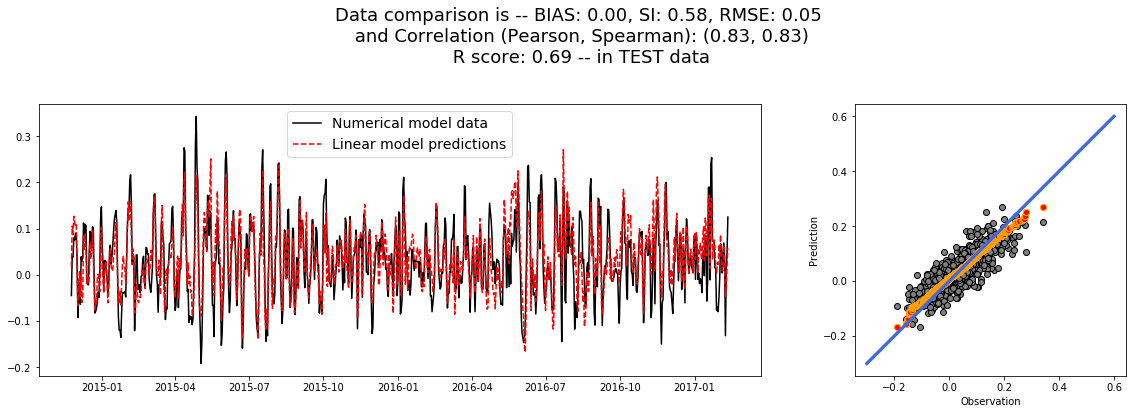

Data comparison is -- BIAS: 0.00, SI: 0.58, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.83, 0.83)
 R score: 0.69 -- in TEST data


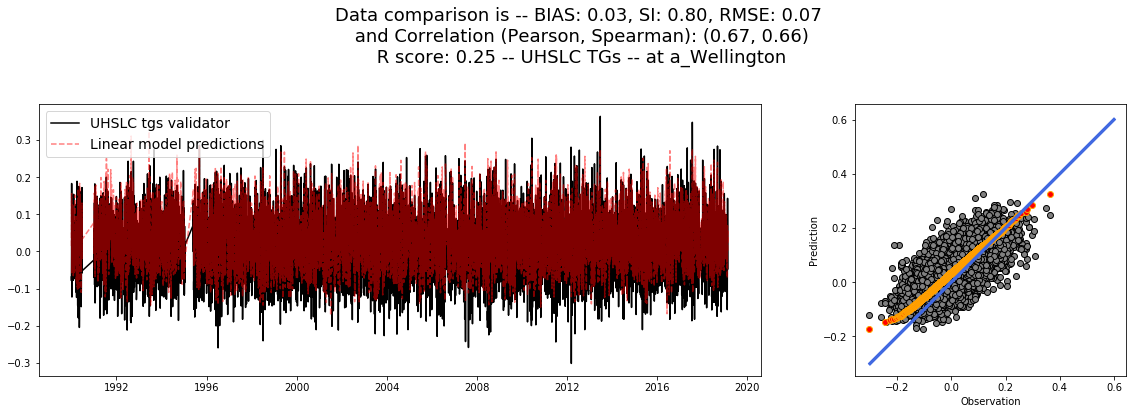


 139 PCs (0.95 expl. variance) will be used to train the model!! 



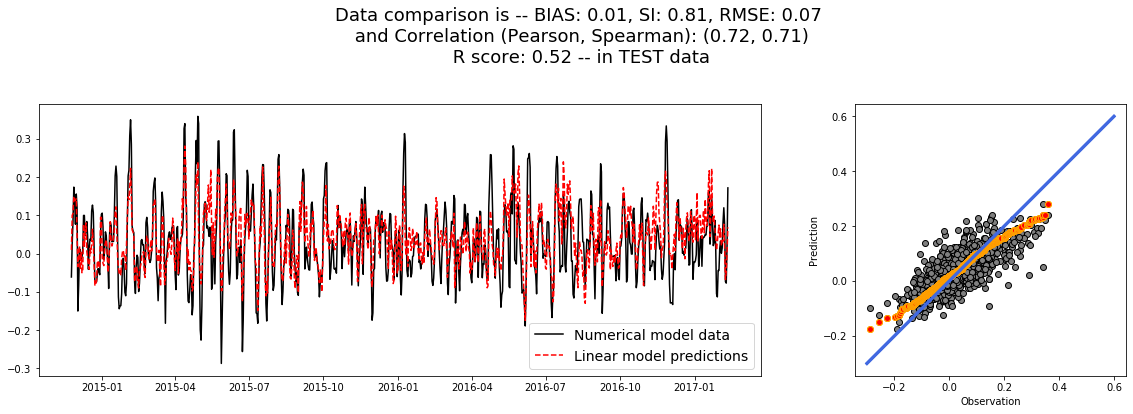

Data comparison is -- BIAS: 0.01, SI: 0.81, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.72, 0.71)
 R score: 0.52 -- in TEST data


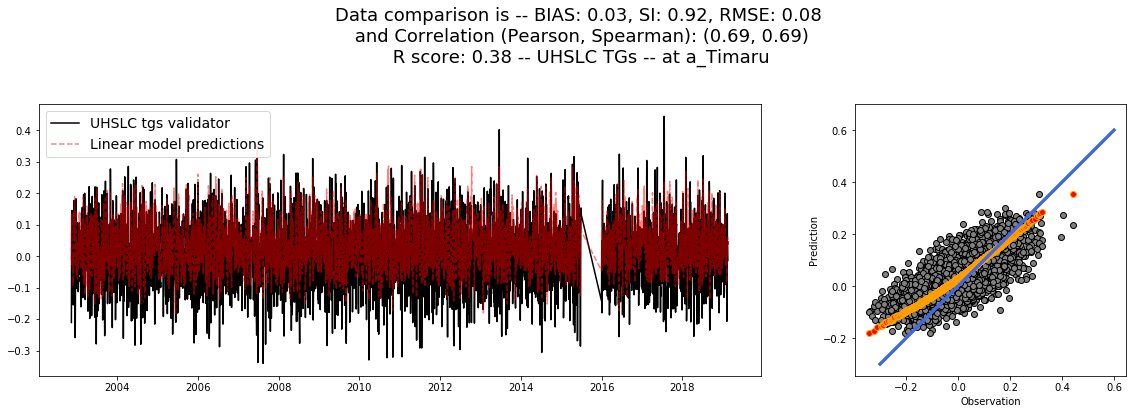


 139 PCs (0.95 expl. variance) will be used to train the model!! 



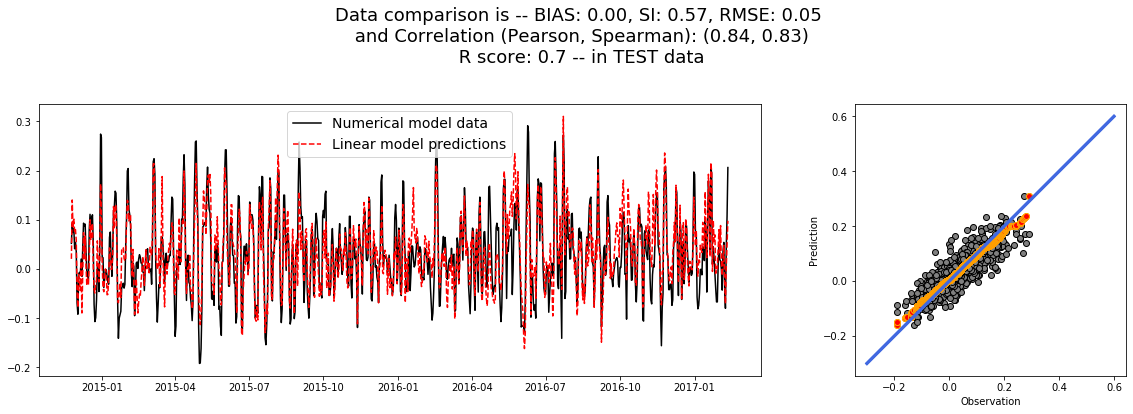

Data comparison is -- BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.84, 0.83)
 R score: 0.7 -- in TEST data


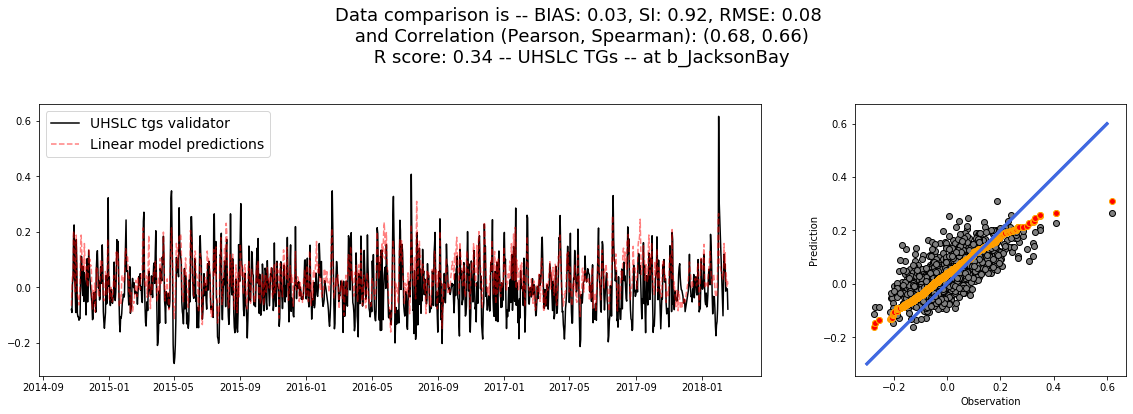


 139 PCs (0.95 expl. variance) will be used to train the model!! 



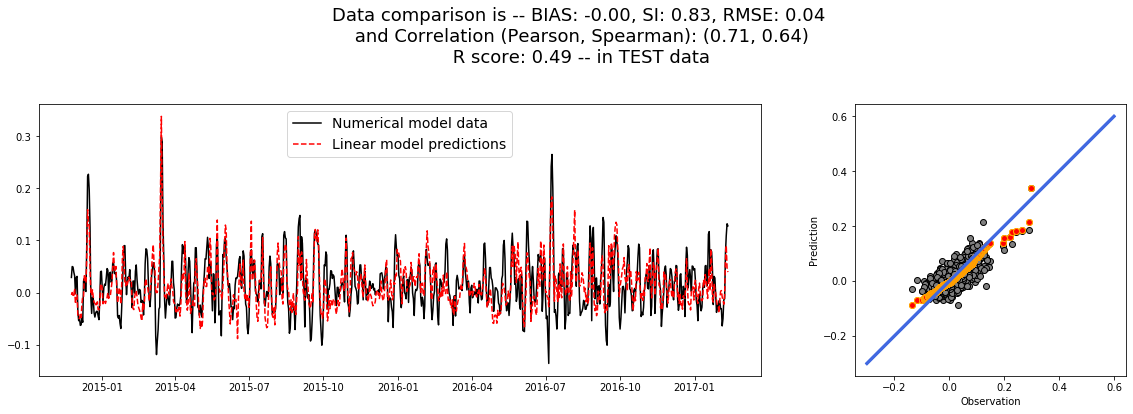

Data comparison is -- BIAS: -0.00, SI: 0.83, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.71, 0.64)
 R score: 0.49 -- in TEST data


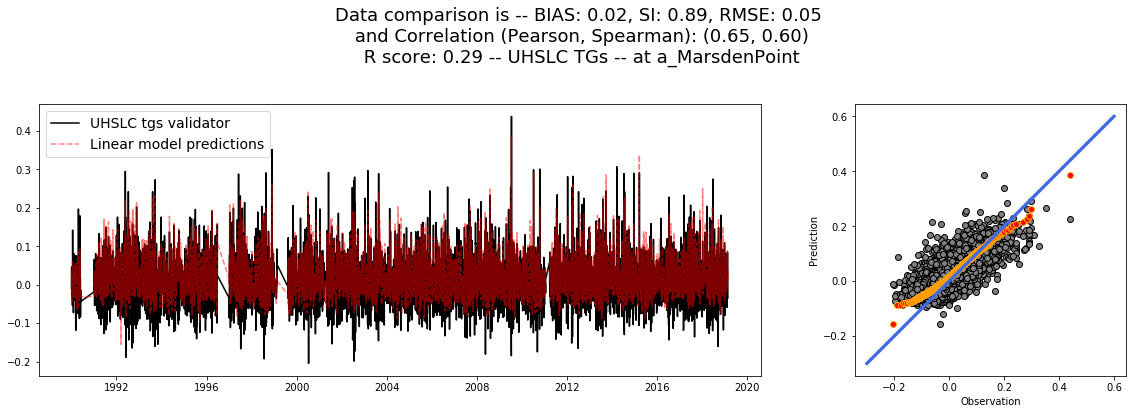


 139 PCs (0.95 expl. variance) will be used to train the model!! 



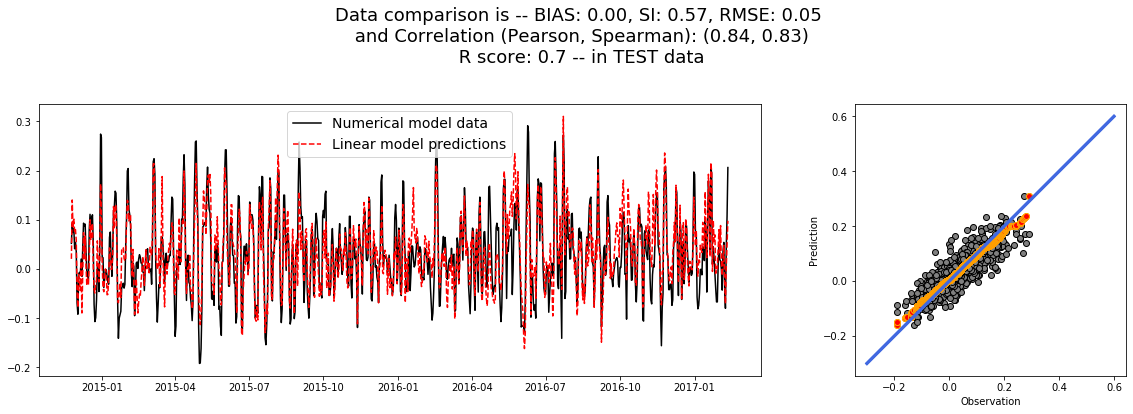

Data comparison is -- BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.84, 0.83)
 R score: 0.7 -- in TEST data


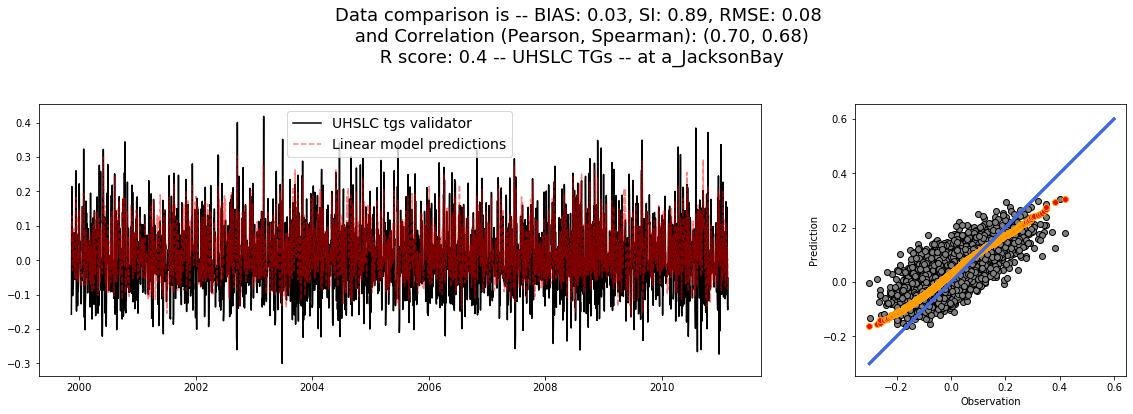


 139 PCs (0.95 expl. variance) will be used to train the model!! 



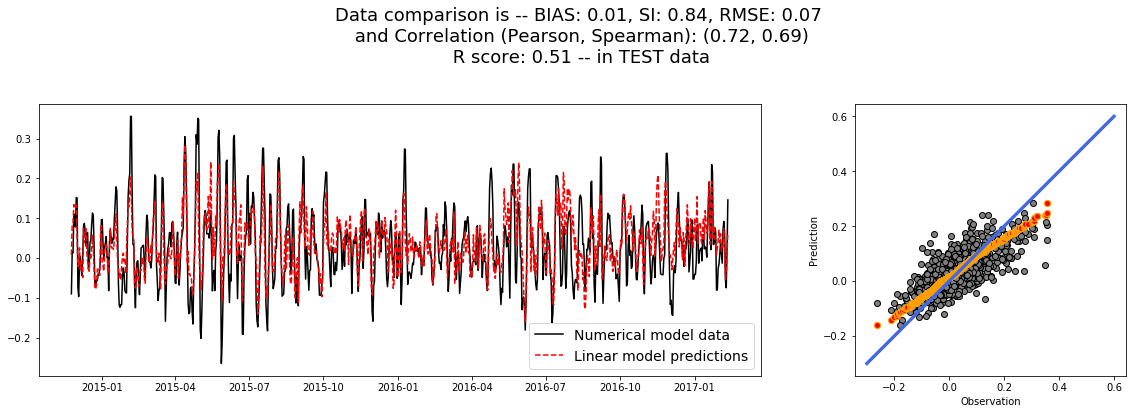

Data comparison is -- BIAS: 0.01, SI: 0.84, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.72, 0.69)
 R score: 0.51 -- in TEST data


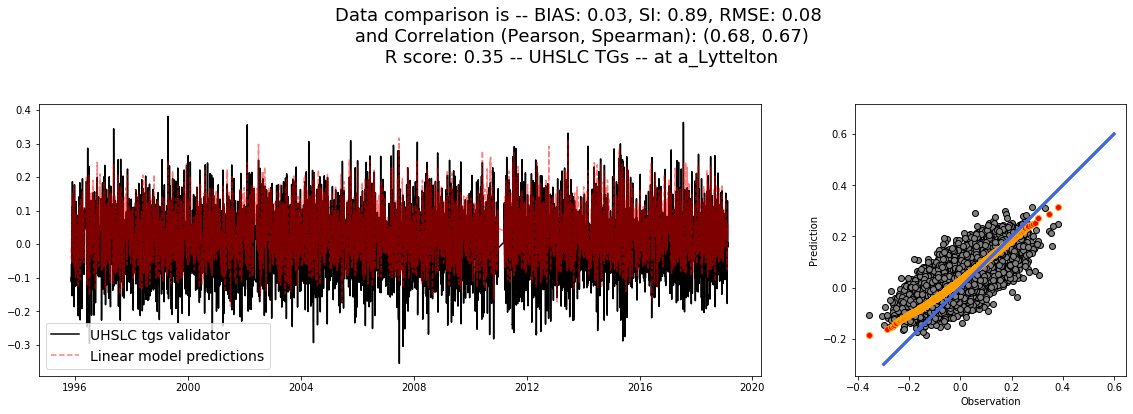


 139 PCs (0.95 expl. variance) will be used to train the model!! 



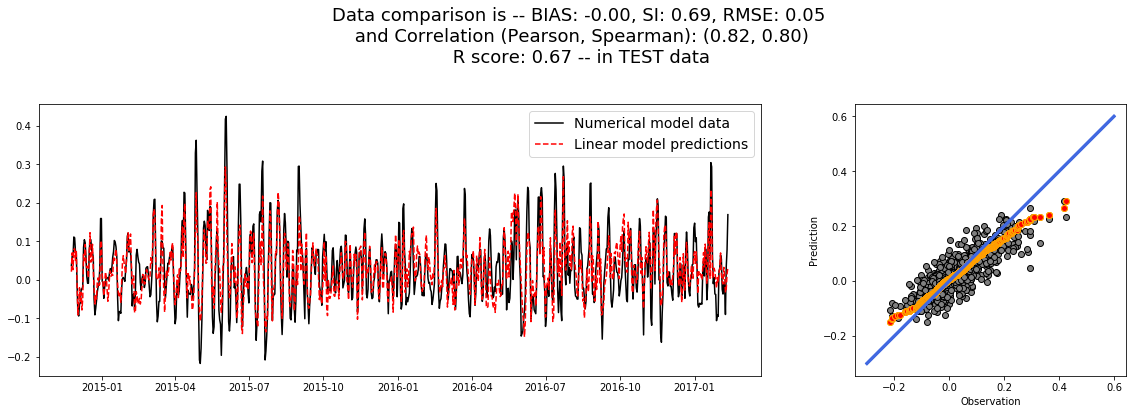

Data comparison is -- BIAS: -0.00, SI: 0.69, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.82, 0.80)
 R score: 0.67 -- in TEST data


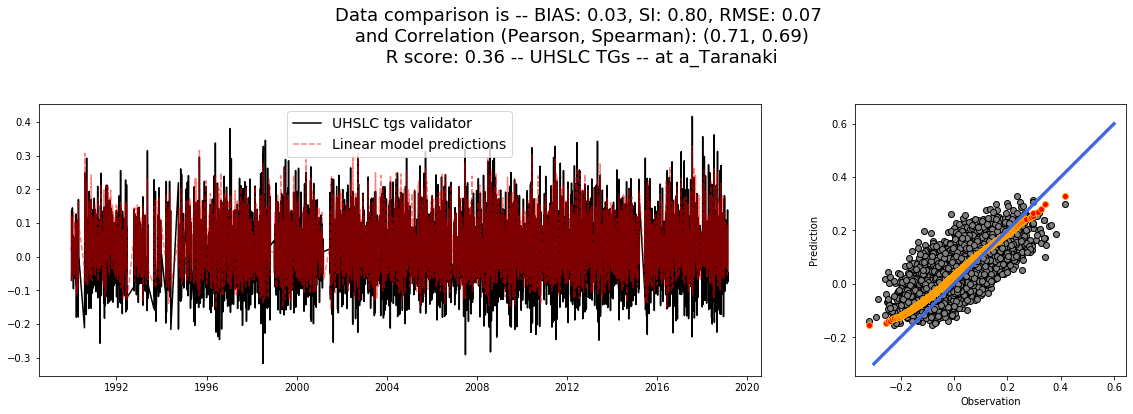


 139 PCs (0.95 expl. variance) will be used to train the model!! 



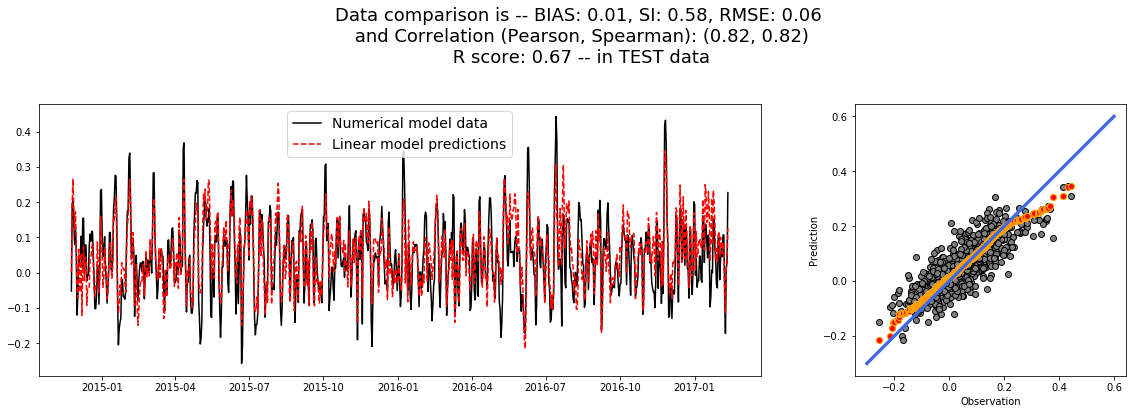

Data comparison is -- BIAS: 0.01, SI: 0.58, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.82, 0.82)
 R score: 0.67 -- in TEST data


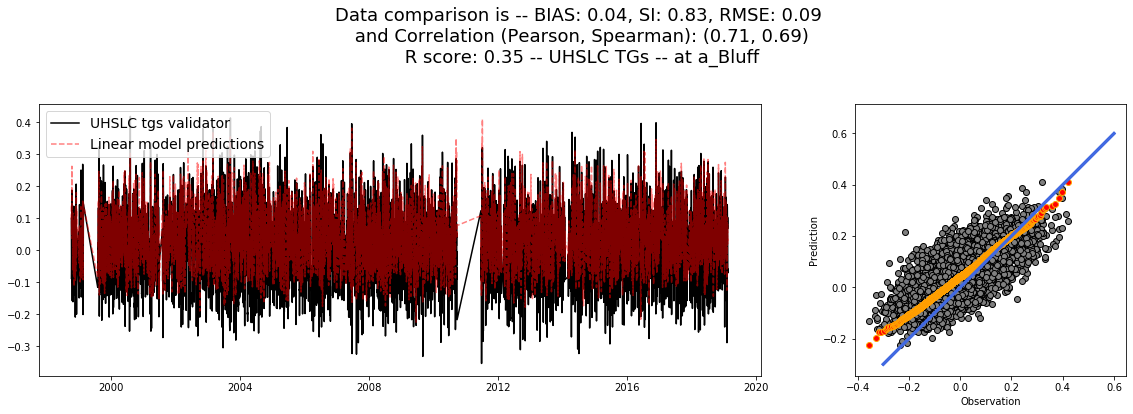


 139 PCs (0.95 expl. variance) will be used to train the model!! 



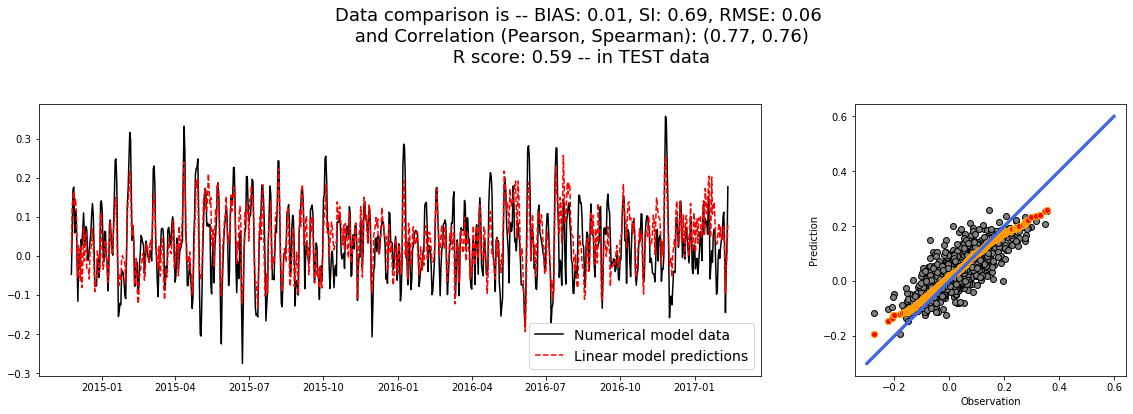

Data comparison is -- BIAS: 0.01, SI: 0.69, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.77, 0.76)
 R score: 0.59 -- in TEST data


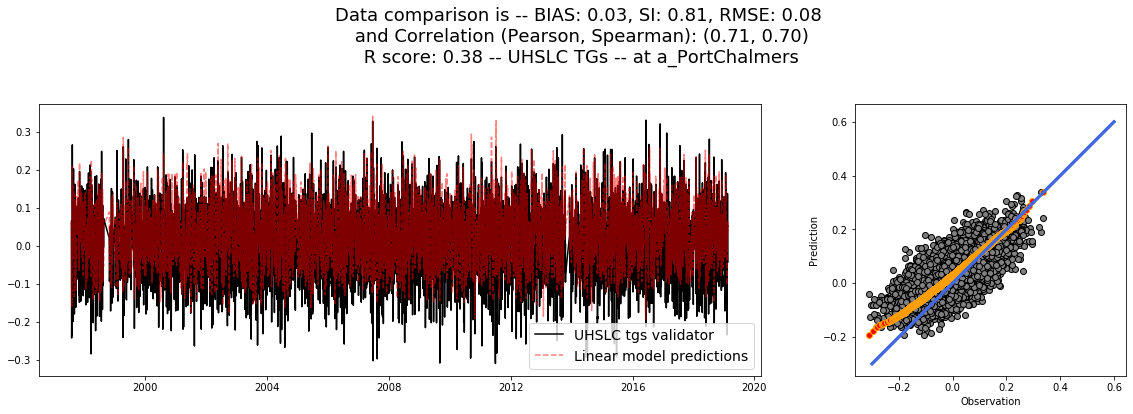


 139 PCs (0.95 expl. variance) will be used to train the model!! 



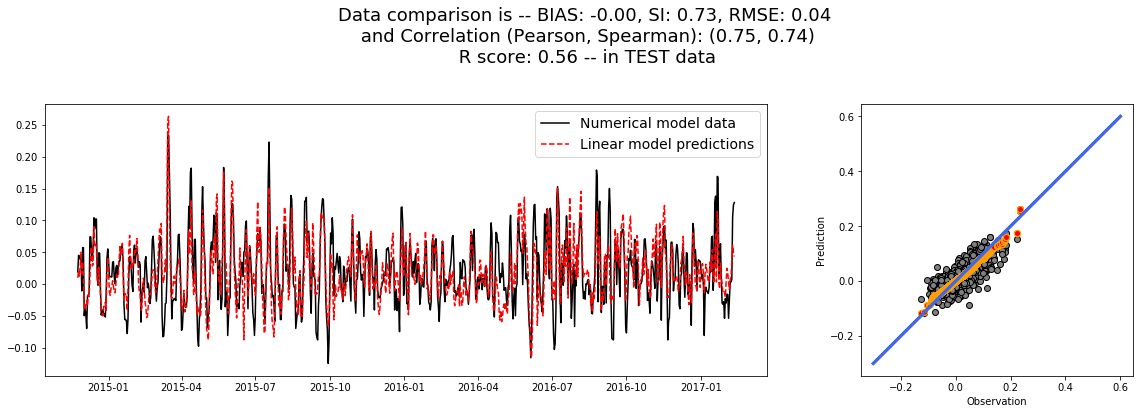

Data comparison is -- BIAS: -0.00, SI: 0.73, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.75, 0.74)
 R score: 0.56 -- in TEST data


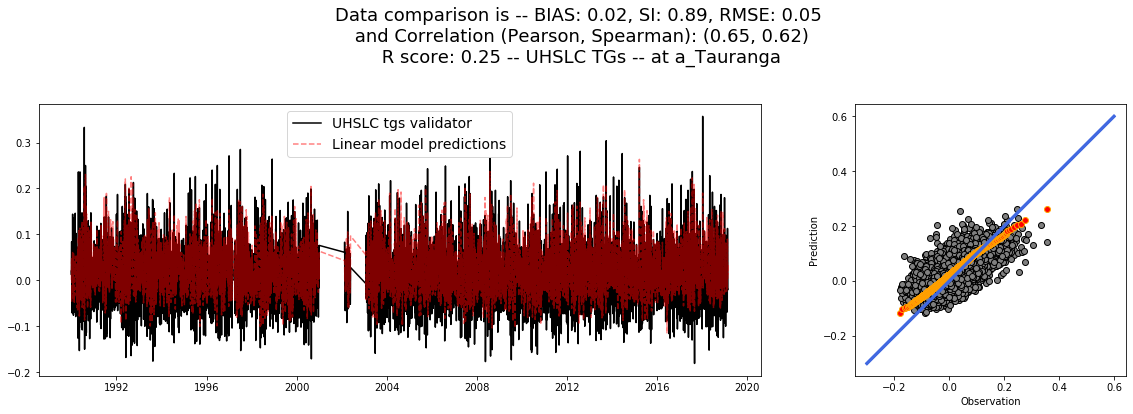


 139 PCs (0.95 expl. variance) will be used to train the model!! 



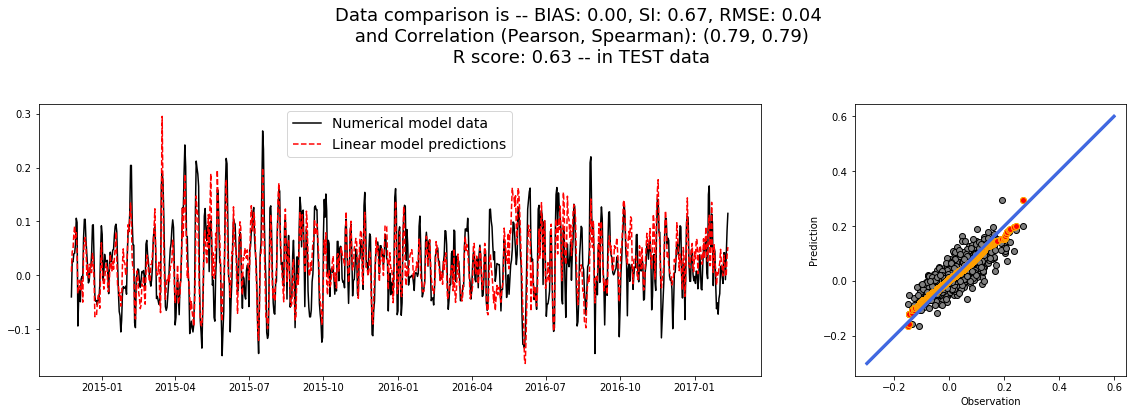

Data comparison is -- BIAS: 0.00, SI: 0.67, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.79, 0.79)
 R score: 0.63 -- in TEST data


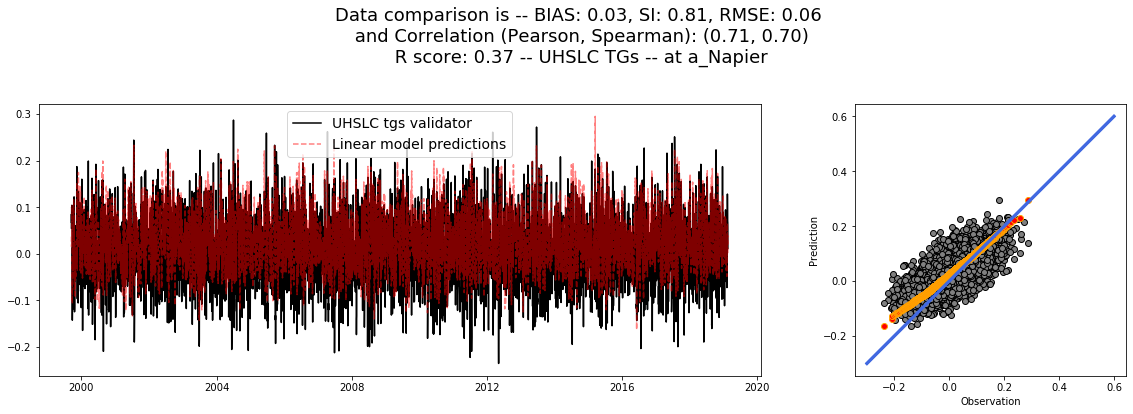


 139 PCs (0.95 expl. variance) will be used to train the model!! 



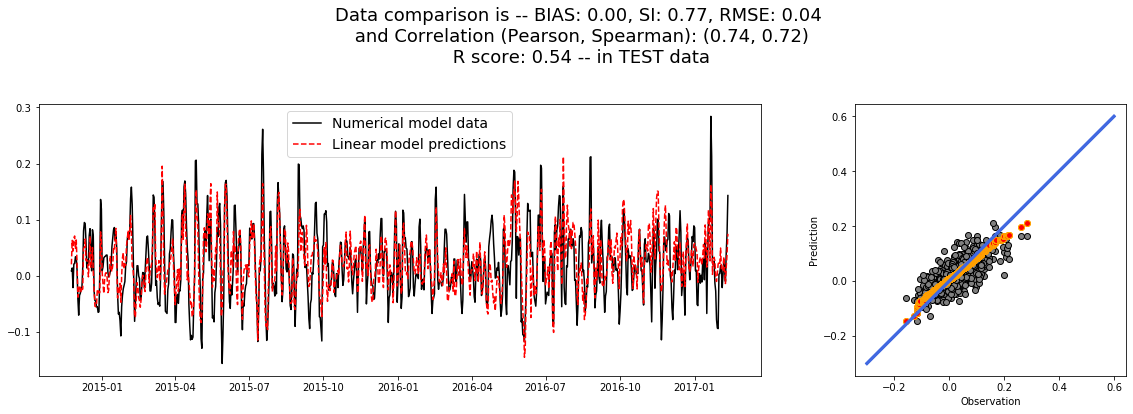

Data comparison is -- BIAS: 0.00, SI: 0.77, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.74, 0.72)
 R score: 0.54 -- in TEST data


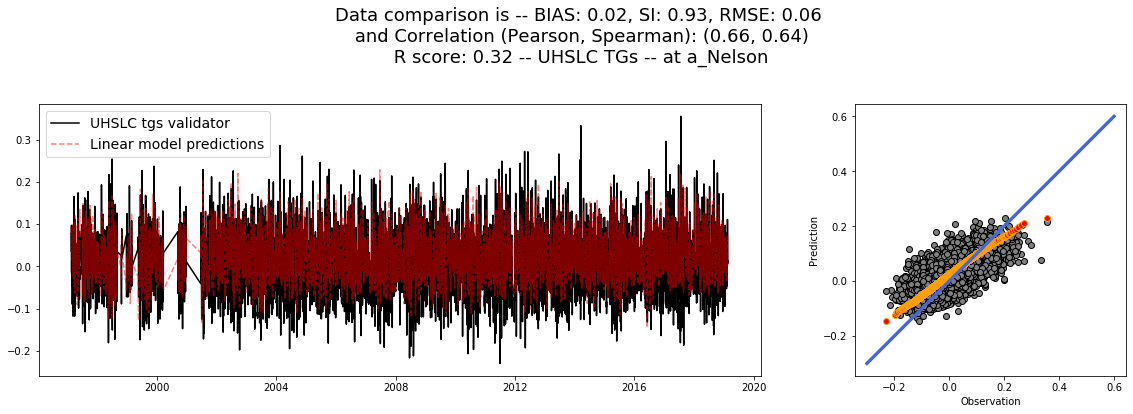

In [7]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat = MultiLinear_Regression(
        pcs_cfsr, ss_moana, plot_results=True,
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        )
    )
    stats.append(stats_stat)

### Linear regression - Ana's paper

In the following two cells, we do the regional-linear regression again, but this time we tarin the model with the tidal guages directly, just to see how our predictors are behaving when compared to results in previous works, as the one available at Rueda et al. 2018:

```{figure} ../media/images/anaetal.png
---
width: 700px
name: anaetal
---
Result from Rueda et al. and some more private tidal guages locations. Full paper available ([here](https://www.researchgate.net/publication/328587769_Marine_climate_variability_based_on_weather_patterns_for_a_complicated_island_setting_The_New_Zealand_case))
```


 loading and plotting the GeoOcean tidal guages... 


 139 PCs (0.95 expl. variance) will be used to train the model!! 



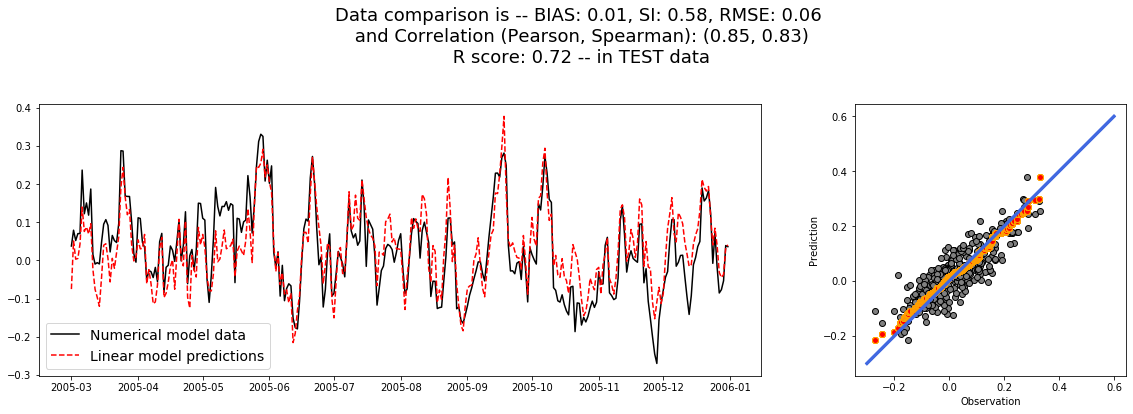

Data comparison is -- BIAS: 0.01, SI: 0.58, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.85, 0.83)
 R score: 0.72 -- in TEST data


In [9]:
# linear regression in kapiti island
ss_kapiti = load_private_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_stat = MultiLinear_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True
)


 loading and plotting the GeoOcean tidal guages... 


 139 PCs (0.95 expl. variance) will be used to train the model!! 



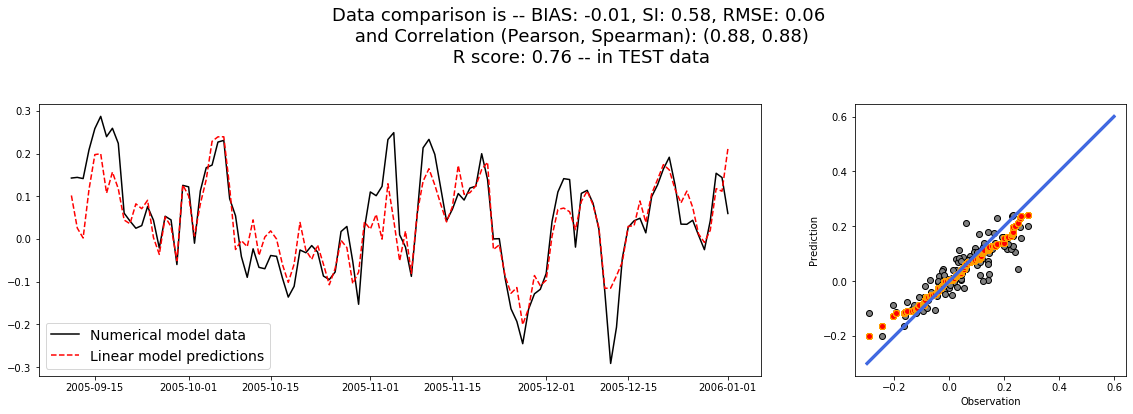

Data comparison is -- BIAS: -0.01, SI: 0.58, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.88, 0.88)
 R score: 0.76 -- in TEST data


In [10]:
# linear regression in green island
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_stat = MultiLinear_Regression(
    pcs_cfsr, ss_green, plot_results=True
)

## Linear regression with local predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the local pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_local_daily.nc`. Notice that, with the regional predictor, which involves an area of 4 $\cdot$ 4 degrees, we are able to cover just a smaller area, but centered at the location of the virtual moana node.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results, as it could be seen with the regional predictor
```

In [11]:
run = False
if run:
    # perform the Multilinear-Regression (local)
    stats_local = []
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),10
    )
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=2,
                region=(True, (
                    ss_moana.lon.values[0]-2.1,
                    ss_moana.lon.values[0]+2.1,
                    ss_moana.lat.values[0]+2.1,
                    ss_moana.lat.values[0]-2.1
                )),
                pca_plot=False, verbose=False
            )[0],
            ss_moana, # tidal gauge (moana v2)
            verbose=False
        )
        stats_local.append(stats_stat)
    # save the statistics
    stats_local = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_local)[:,0]),
            'si':(('station'),np.array(stats_local)[:,1]),
            'rmse':(('station'),np.array(stats_local)[:,2]),
            'pearson':(('station'),np.array(stats_local)[:,3]),
            'spearman':(('station'),np.array(stats_local)[:,4]),
            'rscore':(('station'),np.array(stats_local)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon)
        },
        coords={
            'station': sites_local
        }
    )
    # local copy
    if True:
        stats_local.to_netcdf(data_path+'/statistics/stats_lm_local_daily.nc')
else:
    stats_local = xr.open_dataset(
        data_path+'/statistics/stats_lm_local_daily.nc'
    )

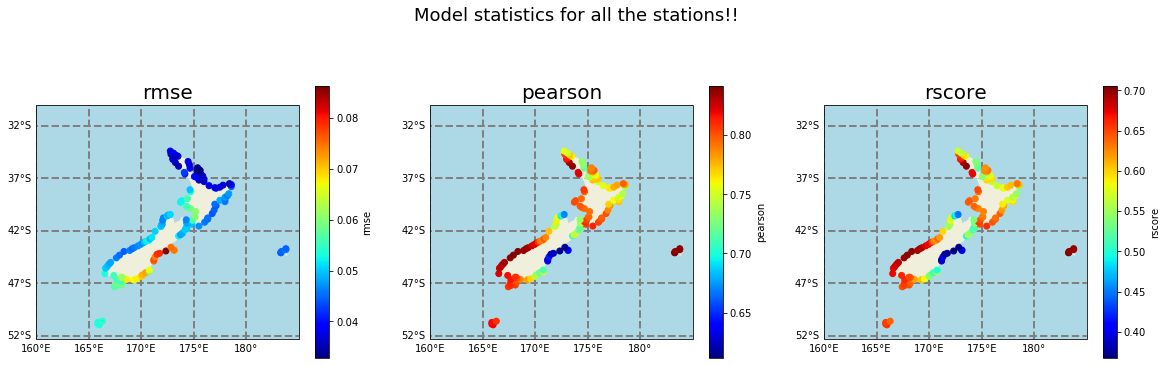

In [12]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_local,plot_stats=['rmse','pearson','rscore'])